In [15]:
# Import necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to SQLite database
conn = sqlite3.connect(':memory:')  # Create an in-memory database
cursor = conn.cursor()


In [16]:

# Load data from Excel file
teacher_activity = pd.read_excel("data.xlsx", sheet_name='Teacher Activity')
student_activity = pd.read_excel("data.xlsx", sheet_name='Student Activity')
data_dictionary = pd.read_excel("data.xlsx", sheet_name='Data Dictonary')

# Write data to SQLite tables
teacher_activity.to_sql('Teacher_Activity', conn, if_exists='replace', index=False)
student_activity.to_sql('Student_Activity', conn, if_exists='replace', index=False)
data_dictionary.to_sql('Data_Dictionary', conn, if_exists='replace', index=False)


34

In [17]:

# SQL Queries

# 1. Top 5 schools with overall teachers’ login% > 60%
query1 = """
SELECT school_name, 
       AVG(CAST(is_present AS INT)) * 100 AS login_percentage
FROM Teacher_Activity
GROUP BY school_name
HAVING login_percentage > 60
ORDER BY login_percentage DESC
LIMIT 5;
"""
top_schools_df = pd.read_sql_query(query1, conn)
top_schools_df



,school_name,login_percentage


In [18]:

# 2. Teachers Login day over day change in percentage across all schools
query2 = """
SELECT school_name,
       DATE(record_date) AS login_date,
       (CAST(SUM(is_present) AS FLOAT) / COUNT(DISTINCT teacher_id)) * 100 AS login_percentage
FROM Teacher_Activity
GROUP BY school_name, login_date
ORDER BY school_name, login_date;
"""
day_over_day_change_df = pd.read_sql_query(query2, conn)
day_over_day_change_df


,school_name,login_date,login_percentage
0,ABU DHABI_1373,2020-10-25,15.384615
1,ABU DHABI_1373,2020-10-26,23.076923
2,ABU DHABI_1373,2020-10-27,15.384615
3,ABU DHABI_1373,2020-10-28,23.076923
4,ABU DHABI_1373,2020-10-29,0.000000
...,...,...,...
191,AL AIN_1775,2020-11-03,11.764706
192,AL AIN_1775,2020-11-04,11.764706
193,AL AIN_1775,2020-11-05,17.647059
194,AL AIN_1775,2020-11-06,0.000000


In [19]:

# 3. If each billable student pays 500$/Month, what’s the revenue generated per school
query3 = """
WITH billable_students AS (
    SELECT school_name, 
           COUNT(DISTINCT student_id) AS billable_student_count
    FROM Student_Activity
    WHERE is_present = 1
    GROUP BY school_name
)
SELECT school_name, billable_student_count * 500 AS revenue_generated
FROM billable_students;
"""
revenue_per_school_df = pd.read_sql_query(query3, conn)
revenue_per_school_df

,school_name,revenue_generated
0,ABU DHABI_1373,84000
1,ABU DHABI_1380,9500
2,ABU DHABI_1476,1500
3,ABU DHABI_1498,82000
4,ABU DHABI_1530,112500
5,ABU DHABI_1620,4000
6,ABU DHABI_1642,7500
7,ABU DHABI_1652,112000
8,ABU DHABI_1706,219000
9,ABU DHABI_176,21000


In [20]:

# 4. Find the number of teachers per school who logged in 3 consecutive days
query4 = """
SELECT school_name, 
       teacher_id, 
       COUNT(DISTINCT DATE(record_date)) AS consecutive_days_logged_in
FROM Teacher_Activity
WHERE is_present = 1
GROUP BY school_name, teacher_id
HAVING consecutive_days_logged_in >= 3;
"""
teachers_consecutive_logins_df = pd.read_sql_query(query4, conn)
teachers_consecutive_logins_df

,school_name,teacher_id,consecutive_days_logged_in
0,ABU DHABI_1373,300440,7
1,ABU DHABI_1373,303432,9
2,ABU DHABI_1373,306517,9
3,ABU DHABI_1373,531571,4
4,ABU DHABI_1498,556158,8
...,...,...,...
73,AL AIN_1562,508232,6
74,AL AIN_1562,508360,5
75,AL AIN_1562,508392,11
76,AL AIN_1775,573625,5


In [21]:

# 5. Find the weekly average for student login activity per school
query5 = """
SELECT school_name, 
       STRFTIME('%Y-%W', record_date) AS week_number,
       AVG(CAST(is_present AS INT)) * 100 AS login_percentage
FROM Student_Activity
GROUP BY school_name, week_number;
"""
weekly_average_logins_df = pd.read_sql_query(query5, conn)
weekly_average_logins_df

,school_name,week_number,login_percentage
0,ABU DHABI_1373,2020-42,10.273973
1,ABU DHABI_1373,2020-43,7.261509
2,ABU DHABI_1373,2020-44,12.678288
3,ABU DHABI_1380,2020-42,0.696864
4,ABU DHABI_1380,2020-43,0.447984
5,ABU DHABI_1380,2020-44,0.754936
6,ABU DHABI_1476,2020-42,0.000000
7,ABU DHABI_1476,2020-43,0.000000
8,ABU DHABI_1476,2020-44,5.555556
9,ABU DHABI_1498,2020-42,32.142857


In [22]:

# Data Visualization
# Plotting top 5 schools with highest teacher login percentage
if not top_schools_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='login_percentage', y='school_name', data=top_schools_df, palette='viridis')
    plt.title('Top 5 Schools with Highest Teacher Login Percentage')
    plt.xlabel('Login Percentage')
    plt.ylabel('School Name')
    plt.show()
else:
    print("No data available for plotting top schools.")


No data available for plotting top schools.


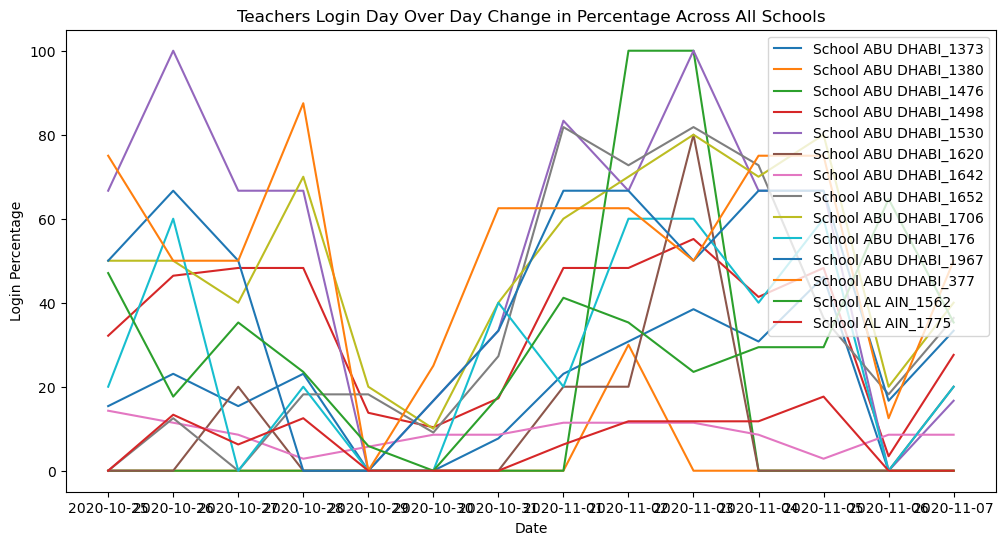

In [23]:

# Plotting teachers login day over day change across all schools
if not day_over_day_change_df.empty:
    plt.figure(figsize=(12, 6))
    for school in day_over_day_change_df['school_name'].unique():
        data = day_over_day_change_df[day_over_day_change_df['school_name'] == school]
        plt.plot(data['login_date'], data['login_percentage'], label=f'School {school}')
    plt.title('Teachers Login Day Over Day Change in Percentage Across All Schools')
    plt.xlabel('Date')
    plt.ylabel('Login Percentage')
    plt.legend()
    plt.show()
else:
    print("No data available for plotting day over day change.")


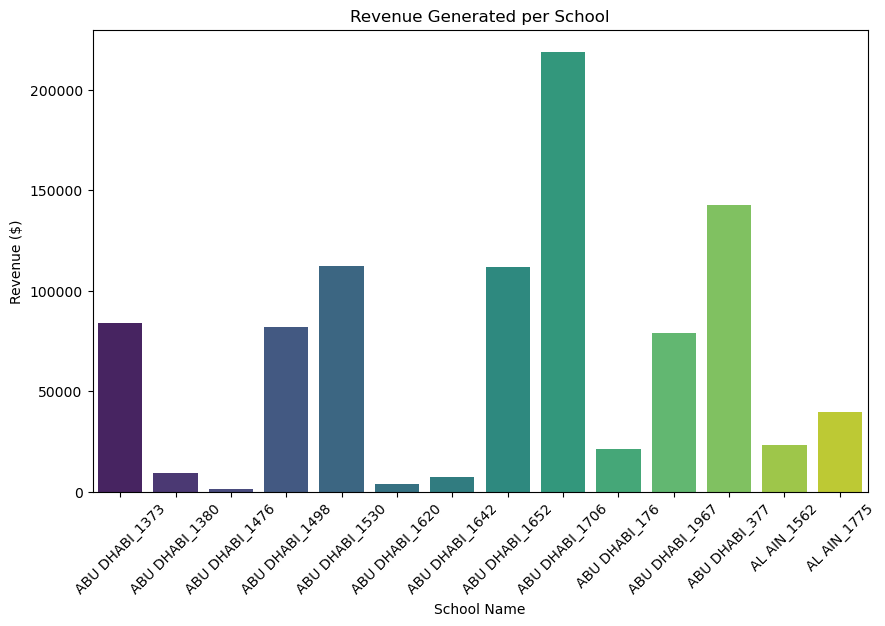

In [24]:

# Plotting revenue generated per school
if not revenue_per_school_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='school_name', y='revenue_generated', data=revenue_per_school_df, palette='viridis')
    plt.title('Revenue Generated per School')
    plt.xlabel('School Name')
    plt.ylabel('Revenue ($)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data available for plotting revenue.")


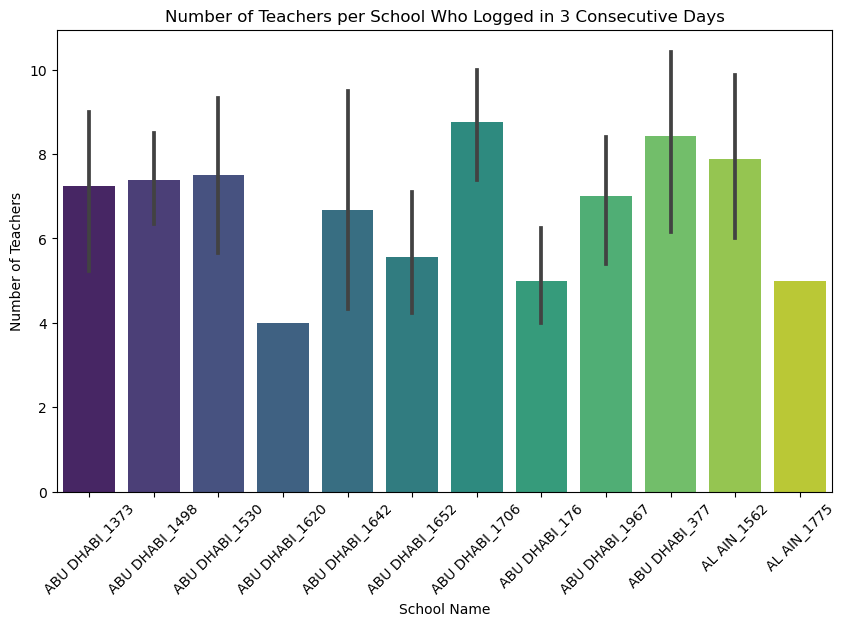

In [25]:

# Plotting number of teachers per school who logged in 3 consecutive days
if not teachers_consecutive_logins_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='school_name', y='consecutive_days_logged_in', data=teachers_consecutive_logins_df, palette='viridis')
    plt.title('Number of Teachers per School Who Logged in 3 Consecutive Days')
    plt.xlabel('School Name')
    plt.ylabel('Number of Teachers')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data available for plotting consecutive logins.")


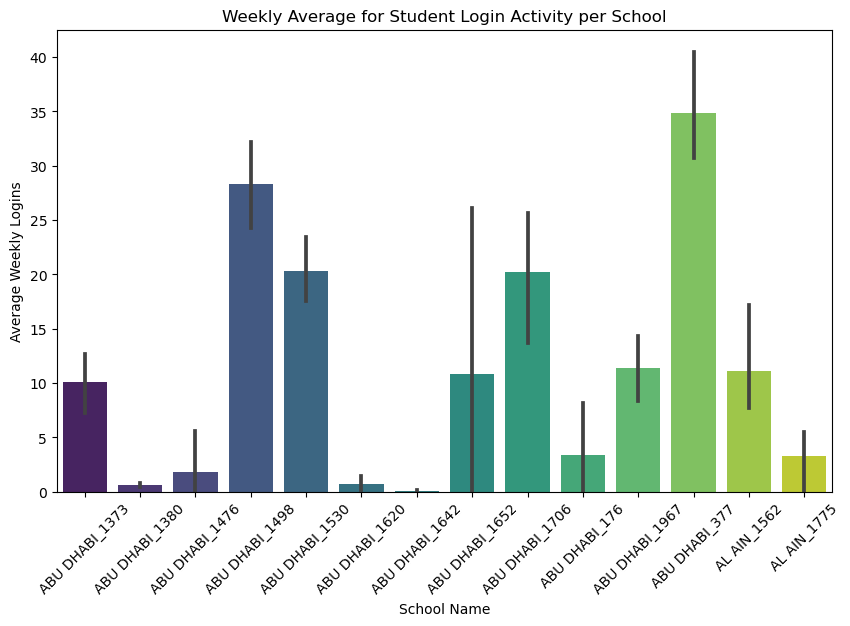

In [26]:

# Plotting weekly average for student login activity per school
if not weekly_average_logins_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='school_name', y='login_percentage', data=weekly_average_logins_df, palette='viridis')
    plt.title('Weekly Average for Student Login Activity per School')
    plt.xlabel('School Name')
    plt.ylabel('Average Weekly Logins')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data available for plotting weekly average logins.")


In [27]:

# Close the database connection
conn.close()
